 ### 📝 **Python Notes:**
 - `np.zeros((H*W*3))` : This uses a tuple to define the shape. This is the ecommended way because tuples are immutable
 - `np.zeros([H*W*3])` :  This uses a list to define the shape. This will work as ell but is not the recommneded way.
 - `np.arange(W)` : Returns a numpy array generating values from 0 to W-1
 - `u,v = np.meshgrid(u,v)` :  If u and v are 1-D vectors with length U and V espectively, this operation returns 2, 2-D vectors of shape (V,U). The new ombination of u,v now represents a 2D grid.


    ```python
    u = np.array([1,2,3])
    v = np.array([4,5])

    u,v = np.meshgrid(u,v)

    # u gets repeated for every row
    # u : [[1,2,3],
    #      [1,2,3]]
    #
    # v gets repeated for every column
    # v: [[4,4,4],
    #     [5,5,5]]


    ```

- `np.linalg.norm(dirs, axis = -1, keepdims=True)`: Normalization function from the linear algebra library. dirs is the input, calculates the mag (sqrt) of the vector along the specified axis, z in this case which is the x,y,z component of each direction vector. keepdims=True makes it so that the result of this operation is still a 3D vector with size 1 in the 3rd dimension (H,W,1). This enables using it to divide a 3D vector. Without it, the result would be a 2D vector (H,W).
- `rays_dir.reshape(-1,3)` : This reshapes the 3D vector from (H,W,3) to 2D vector of shape (H*W,3). 
- `x[:,0]` : This is a way to slice a 2D vector. The colon in the first place means, take all the rows and 0 means take only column 0.
- `torch.linspace(start,end,steps)` : Generates a 1D tensor of evenly spaced values between a specified start and end over a given number of steps.
- `unsqueeze` :  Adds an additional dimention at the specified axis. Can also use `reshape` but unsqueeze is preferred for adding dimension because you don't need to explicitly calculate all the dimension lengths.

    ```python
    x = torch.tensor([1, 2, 3])  # Shape: (3,)

    # Add a new dimension at position 0
    x_unsqueezed = x.unsqueeze(0)  # Shape: (1, 3)

    # Add a new dimension at position 1
    x_unsqueezed_1 = x.unsqueeze(1)  # Shape: (3, 1)
    ```

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import torch

### **Step 1:** Define the properties of the target image to be rendered

- H - Height of the image
- W - Width of the image
- F - Distance between the camera origin and image plane

In [38]:
H = 300   
W = 400   
F = 1200 

### **Step 2:** Setup the ray origin and directions
- Assume one ray per pixel of the image going through the center of the pixel
- `u,v` coordinate system used for the image where u goes along the width from left to right and v goes along the height from top to bottom. Top left is the origin.
- Camera is assumed to be at the center of the image, F units away
- Even though origin of all the rays is the same, a vector is created so that ray point calculations are easier and all use the same shape
- `dirs` are calculated assuming camera as the origin with y axis pointing upward and z axis pointing out of the  screen. They are just the subtraction for the point on the image plane and the origin. They are NOT unit vectors.
- `dirs` are then normalized and reshaped back to 2D vectors. It is common in raytracing operations to flatten all the pixels in a vector.

In [39]:
rays_origin = np.zeros((H*W, 3))
rays_dir = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u,v = np.meshgrid(u,v) # shape (H,W)

dirs = np.stack(
    (
        u - W / 2,
        - (v - H / 2),
        - np.ones_like(u) * F
    ),
    axis=-1
) # shape (H,W,3)

rays_dir = dirs/np.linalg.norm(dirs, axis = -1, keepdims=True) #shape (H,W,3)
rays_dir = rays_dir.reshape(-1,3) #shape (H*W,3)

### Step 3: Define the Sphere object
- `intersect` function takes in a point instead of a ray (typical) because we are calculating intersections with multiple points along every ray and then aggregating the results from them. This is the basis for volumetric rendering.
- Condition for intersection with a sphere is 

    $(x- x_c)^2 + (y-y_c)^2 + (z-z_c)^2 <= r^2 $

In [45]:
class Sphere:
    def __init__(self, center, radius, color):
        self.center = center
        self.radius = radius
        self.color = color

    # points is expected to be of shape (num_points, 3)
    def intersect(self, points):

        condition = ( points[:,0] - self.center[0] )**2 + \
            ( points[:,1] - self.center[1] )**2 + \
            ( points[:,2] - self.center[2] )**2  <=  self.radius**2
        
        num_points = points.shape[0]
        colors = torch.zeros((num_points,3)) # RGB
        densities = torch.zeros((num_points,1))

        colors[condition] = self.color
        densities[condition] = 10

        return colors, densities


### Step 4 : Create the rendering function
- Along each ray there will be a number of points selected where we will do the intersection test, calculate the density and color and aggregate them for the final color of that ray.
- **Accumulated transmittance** is the probability that the ray reaches a particular point without hitting any other particle. So, if there are 2 walls, one behind the other, the wall at the back should not contribute to the color of the ray.
    As per the paper:

    $\alpha_i = 1 - exp(X_i)  where X_i = \sigma_i * \delta_i$
    
    We are passing this value to the compute method: 

    $1 - \alpha_i = exp(X_i)$

    So our input looks something like this

    |    0     |    1     |    2     |    3     |
    |----------|----------|----------|----------|
    | exp(X_0) | exp(X_3) | exp(X_2) | exp(X_3) |
    

    $T_i = exp(\sum_{j=1}^{i-1}X_j)$

    So, 
    $T_2 = exp(X_1)$

    $T_3 = exp(X_1 + X_2)$

    $T_4 = exp(X_1 + X_2 + X_3)$ ...

    This can also be written as:

    $T_3 = exp(X_1) * exp(X_2)$

    $T_4 = exp(X_1) * exp(X_2) * exp(X_3)$ ...

    which is essentially the cumulative product
- **Rendering equation**: The final color of a ray, in a simplistic way is a product of the accumulated transmittance, color, and the alpha blending of a point, summed over all the points over the ray.


In [54]:
def compute_accumulated_transmittance(input):
    # input is of shape (num_rays, num_bins)
    # output is of shape (num_rays, num_bins)
    
    accumulated_transmittance = torch.cumprod(input, dim=1)
    accumulated_transmittance[:,0] = 1
    return accumulated_transmittance

# tn, tf - near and far plane
# num_bins - number of discrete bins the summation is done over
def render(model, rays_origin, rays_dir, tn, tf, num_bins=100, device = 'cpu'):
    
    # Discrete points along each ray
    t = torch.linspace(tn, tf, num_bins).to(device)

    # Delta is same for all points except the last one which is a large value
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))

    # We need a points vector of shape (num_rays, num_bins, 3)
    # rays_origin and rays_dir is of shape (num_rays, 3)
    # t is of shape (num_bins,)
    
    points = rays_origin.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_dir.unsqueeze(1) 

    colors, densities = model.intersect(points.reshape(-1,3))

    # Reshape to (num_rays, num_bins, 3)
    colors = colors.reshape(points.shape[0], num_bins, 3)
    densities = densities.reshape(points.shape[0], num_bins)

    alpha = 1 - torch.exp(- densities * delta.unsqueeze(0))

    T = compute_accumulated_transmittance(1 - alpha)

    final_color = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [numrays, 3]

    return final_color

In [56]:
sphere_position = torch.tensor([0, 0, -1])
sphere_radius = 0.1
sphere_color = torch.tensor([1., 0., 0.])

model = Sphere(sphere_position, sphere_radius, sphere_color)

near_plane = 0.8
far_plane = 1.2
image_color = render(model, torch.tensor(rays_origin), torch.tensor(rays_dir), near_plane, far_plane)

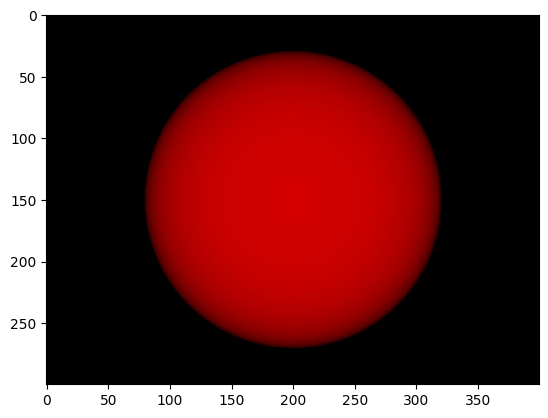

In [60]:
image = image_color.reshape(H, W, 3).cpu().numpy()
plt.imshow(image)